### Imports

In [34]:
!pip install networkx

In [35]:
import sys
import pickle
import pandas as pd
import ipywidgets as widgets
import datetime
import networkx as nx

MODULES_PATH = "../modules"
if MODULES_PATH not in sys.path:
    sys.path.append(MODULES_PATH)

In [36]:
from hive_wrapper import *
from database import *
from utils import *
from route_planner import *
from visualization import * 

%reload_ext autoreload
%autoreload 2

In [37]:
username = "boukil"
_, host, port = get_env_vars()
hive_connection = HiveConnection(username, host, port)
db = Database(hive_connection)

### Load the Network and Necessary Data

In [38]:
!git lfs pull

In [39]:
with open("../data/transport_network.pkl", "rb") as f:
    graph = pickle.load(f)

In [40]:
with open("../data/stops.pkl", "rb") as f:
    stops_df = pickle.load(f)

In [41]:
# build graph to find railway path
railway_route = pd.read_csv("../data/linie-mit-polygon.csv", encoding='latin1')
graph_coordinate = build_coordinate_graph(railway_route)

In [42]:
# Needs to be in this notebook for widgets interaction
start_search = widgets.Button( 
    description='Start search', 
    disabled=False, 
    button_style='info', # 'success', 'info', 'warning', 'danger' or '' 
    tooltip='Run button function', 
    icon='play' 
    ) 

def on_run_button_clicked(b): 
    with output_box: 
        print('running...') 
        global travel_success
        global n_trips
        travel_success, travel_time, id_arrival, id_departure, n_trips = get_input_value(input_success, input_time, input_arrival, input_departure, stops_df, number_input)
        deadline = datetime.datetime.strptime(input_time.value.strftime('%H:%M:%S'), '%H:%M:%S')
        rp = RoutePlanner(graph, id_departure, id_arrival, deadline=deadline, database=db)
        global route 
        route = rp.find_paths(n_trips)
        print('Done with computing')
def get_input_value(input_success, input_time, input_arrival, input_departure, stops_df, number_input):
    ''' Get all input values'''
    # Get departure_id: If parent station available, take parent. Otherwise take last 
    if input_arrival.value =='' or input_departure == '':
        print('\n Error: Input is not complete. Please fill in your travel information')
        sys.exit()
    sub_dep = stops_df[stops_df.stop_name == input_departure.value]
    if len(sub_dep) ==1:
        id_departure = sub_dep.stop_id.iloc[0]
    elif sub_dep.parent_station.iloc[0] != '':
        id_departure =sub_dep.parent_station.iloc[0]
    else: id_departure = sub_dep.stop_id.iloc[-1]

    # Same for arrival_id
    sub_dep = stops_df[stops_df.stop_name == input_arrival.value]
    if len(sub_dep) ==1:
        id_arrival = sub_dep.stop_id.iloc[0]
    elif sub_dep.parent_station.iloc[0] != '':
        id_arrival =sub_dep.parent_station.iloc[0]
    else: id_arrival = sub_dep.stop_id.iloc[-1]

    # Get other values from input directly
    travel_success = input_success.value
    travel_time = input_time.value
    n_trips = int(number_input.value)
    return travel_success, travel_time, id_arrival, id_departure, n_trips

# Validation

## Simple examples 
We are first going to check the viability of our route planner based on a few frequent trips that a Zürich citizen might take :

**Start** : Zürich HB   
**End** : Zürich Auzelg   
**Deadline Date** : 29/05/2023  16:30:00  
**Path picking condition** : Path with the latest departure time

In [13]:
interface, input_success, input_arrival, input_departure, input_time, number_input = build_input(stops_df)
start_search
display(interface)
output_box = widgets.Output() 
display(start_search, output_box) 
start_search.on_click(on_run_button_clicked)

Button(button_style='info', description='Start search', icon='play', style=ButtonStyle(), tooltip='Run button …

Output()

Dropdown(description='Get details about route:', layout=Layout(width='25%'), options=(1, 2), style=Description…

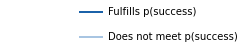

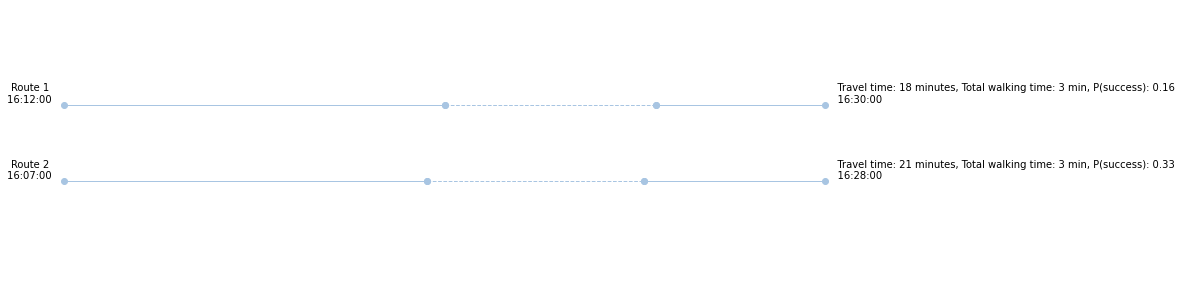

In [14]:
choose_trip = get_choosetrip_w(route)
figure, stops_tot, transport_type , arrival_tot, departure_tot, x_tot, keep_index_tot, type_edge_tot, route_name_tot, headsign_tot, stops_id_tot, trip_id_tot= timetable_overview(route, travel_success, n_trips)
choose_trip

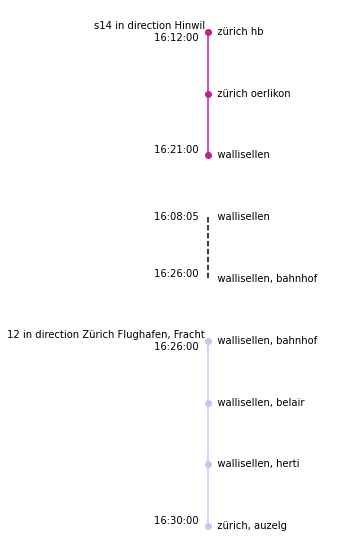

In [16]:
y_label, color_segment, departure_seg, arrival_seg, travel_name, line_style, figure  = detailed_viz1(choose_trip, stops_tot, route_name_tot, headsign_tot, trip_id_tot, keep_index_tot, type_edge_tot, departure_tot, arrival_tot)

You can see that fundamentally this first example corresponds to the following SBB query : 
![Zürich HB -> Zürich Aulzeg](../modules/validation_images/toy_example.png)

Our route planner algorithm had the assumptions of having a deadline hour to choose, and pick the latest arrival time to give to the user. In this example, we see that the deadline hour is 16:30:00, so our algorithm will pick the path arriving in source station at 16:12:00 :
![Path picked](../modules/validation_images/toy_example_hb_auzelg.png)

**Start** : Zürich HB  
**End** : Kloten, Kasern OST  
**Deadline Date** : 29/05/2023  16:00:00  
**Path picking condition** : Path with the latest departure time

In [24]:
interface, input_success, input_arrival, input_departure, input_time, number_input = build_input(stops_df)
start_search
display(interface)
output_box = widgets.Output() 
display(start_search, output_box) 
start_search.on_click(on_run_button_clicked)

Button(button_style='info', description='Start search', icon='play', style=ButtonStyle(), tooltip='Run button …

Output()

Dropdown(description='Get details about route:', layout=Layout(width='25%'), options=(1,), style=DescriptionSt…

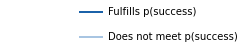

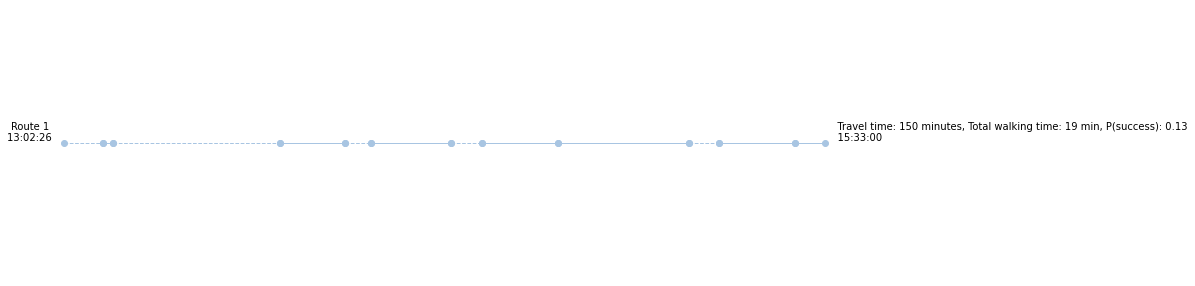

In [49]:
choose_trip = get_choosetrip_w(route)
figure, stops_tot, transport_type , arrival_tot, departure_tot, x_tot, keep_index_tot, type_edge_tot, route_name_tot, headsign_tot, stops_id_tot, trip_id_tot= timetable_overview(route, travel_success, n_trips)
choose_trip

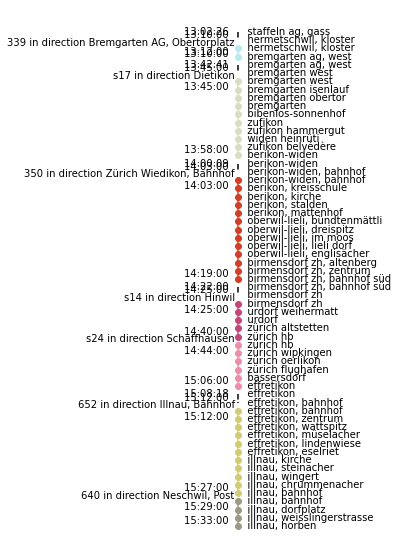

In [48]:
y_label, color_segment, departure_seg, arrival_seg, travel_name, line_style, figure  = detailed_viz1(choose_trip, stops_tot, route_name_tot, headsign_tot, trip_id_tot, keep_index_tot, type_edge_tot, departure_tot, arrival_tot)

## Distance based validation
We first compute the pairwise of all stops in the Zürich area, and order them by their Haversine distance which is the angular distance between two points on the surface of a sphere. As explained earlier, we are going to randomly choose several stop pairs from different distance quartiles, extreme points and compare the path outputed by our planner with the official SBB planner, with the assumptions presented earlier.

In [ ]:
%%spark
import numpy as np

from pyspark.sql import functions as F
from pyspark.sql.window import Window
import pickle

username = "ouerghem"
stops_df = spark.read.orc(f"/user/{username}/preprocessed/pp_stops")

# Constants
EARTH_RADIUS = 6371 * 1e3  # in meters

def haversine_dist(x_lat, x_lon, y_lat, y_lon, in_radian=False):
    """
    Calculate the Haversine distance between two points given their latitudes and longitudes.
    """
    # Convert to radians if needed
    if not in_radian:
        x_lon = F.radians(x_lon)
        x_lat = F.radians(x_lat)
        y_lon = F.radians(y_lon)
        y_lat = F.radians(y_lat)

    sin2_lat = F.pow(F.sin(0.5 * (y_lat - x_lat)), 2)
    sin2_lon = F.pow(F.sin(0.5 * (y_lon - x_lon)), 2)
    cos_lat_prod = F.cos(y_lat) * F.cos(x_lat)

    # Distance in meters
    dist = 2 * EARTH_RADIUS * F.asin(F.sqrt(sin2_lat + cos_lat_prod * sin2_lon))
    return dist
stops_df = stops_df.filter(F.col("stop_name") != "hausen am albis, post")
distance_df = stops_df.alias("a").crossJoin(stops_df.alias("b")) \
    .select(
        F.col("a.stop_id").alias("stop_id_a"),
        F.col("a.stop_name").alias("stop_name_a"),
        F.col("a.stop_lat").alias("stop_lat_a"),
        F.col("a.stop_lon").alias("stop_lon_a"),
        F.col("b.stop_id").alias("stop_id_b"),
        F.col("b.stop_name").alias("stop_name_b"),
        F.col("b.stop_lat").alias("stop_lat_b"),
        F.col("b.stop_lon").alias("stop_lon_b")
    ) \
    .withColumn("distance", haversine_dist(
        F.col("stop_lat_a"),
        F.col("stop_lon_a"),
        F.col("stop_lat_b"),
        F.col("stop_lon_b")
    ))

window_spec = Window.partitionBy("stop_id_a").orderBy(F.desc("distance"))
farthest_stops_df = distance_df.withColumn("rank", F.row_number().over(window_spec)) \
    .filter(F.col("rank") == 1) \
    .select(
        F.col("stop_id_a"),
        F.col("stop_name_a"),
        F.col("stop_id_b"),
        F.col("stop_name_b"),
        F.col("distance")
    ) \
    .orderBy(F.desc("distance"))

quantiles = [0.25, 0.5, 0.75]  

quantile_values = distance_df.approxQuantile("distance", quantiles, 0.25)
quantile_dataframes = []
for i, quantile in enumerate(quantiles):
    lower_bound = quantile_values[i-1] if i > 0 else float("-inf")
    upper_bound = quantile_values[i]
    quantile_df = distance_df.filter((F.col("distance") > lower_bound) & (F.col("distance") <= upper_bound))
    quantile_dataframes.append(quantile_df)
    
quantile_stop_list = []
for i, quantile in enumerate(quantiles):
    print(f"Quantile {quantile}: {quantile_values[i]}")
    quantile_stop_list.append(quantile_dataframes[i].rdd.map(tuple).take(20))
    print("----------------------")
    
farthest_stops_list = farthest_stops_df.rdd.map(tuple).take(40)
median_distance_stops = quantile_stop_list[1]
median_distance_stops

### Median distanced stops

In [17]:
median_stops = [('8503056', 'ringlikon', '8503061', 'langwies zh', 17844.102198839013), 
                ('8503056', 'ringlikon', '8503147:0:2', 'stettbach', 9836.060680752431), 
                ('8503056', 'ringlikon', '8503303:0:2', 'illnau', 19240.228583997417), 
                ('8503056', 'ringlikon', '8573205:0:N', 'zürich flughafen, bahnhof', 11918.666352882656), 
                ('8503056', 'ringlikon', '8573260', 'höri, fuhrstrasse', 16837.83763362294), 
                ('8503056', 'ringlikon', '8576131', 'volketswil, eichstrasse', 15892.450993160162)]

**Start** : Ringlikon   
**End** : Langwies ZH     
**Deadline Date** : 29/05/2023  8:30:00  
**Path picking condition** : Path with the latest departure time

In [29]:
interface, input_success, input_arrival, input_departure, input_time, number_input = build_input(stops_df)
start_search
display(interface)
output_box = widgets.Output() 
display(start_search, output_box) 
start_search.on_click(on_run_button_clicked)

Button(button_style='info', description='Start search', icon='play', style=ButtonStyle(), tooltip='Run button …

Output()

Dropdown(description='Get details about route:', layout=Layout(width='25%'), options=(1,), style=DescriptionSt…

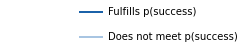

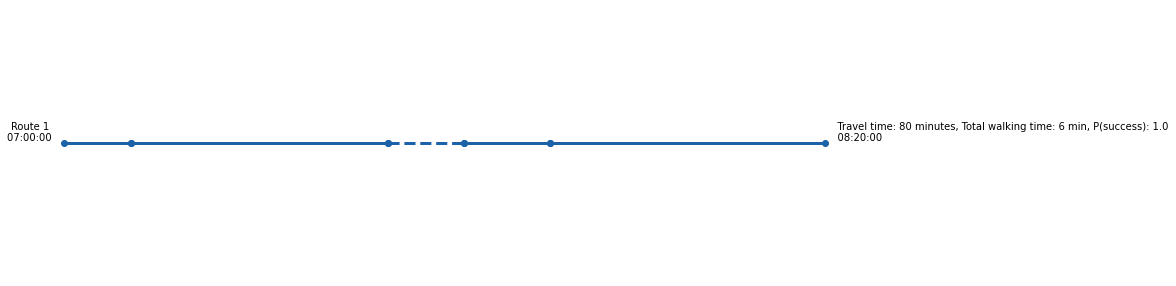

In [30]:
choose_trip = get_choosetrip_w(route)
figure, stops_tot, transport_type , arrival_tot, departure_tot, x_tot, keep_index_tot, type_edge_tot, route_name_tot, headsign_tot, stops_id_tot, trip_id_tot= timetable_overview(route, travel_success, n_trips)
choose_trip

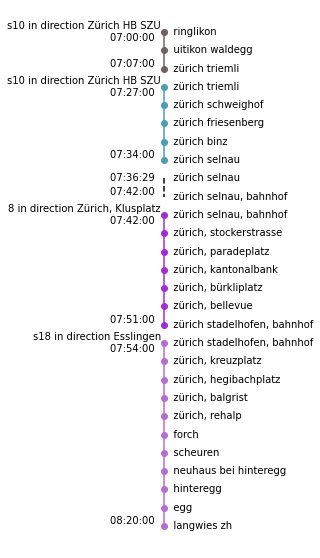

In [31]:
y_label, color_segment, departure_seg, arrival_seg, travel_name, line_style, figure  = detailed_viz1(choose_trip, stops_tot, route_name_tot, headsign_tot, trip_id_tot, keep_index_tot, type_edge_tot, departure_tot, arrival_tot)

A second example, this time for the median distance separated stops, the difference with the SBB planner can now be explained by the fact that our algorithm prioritizes paths that departs as late as possible and then have the lowest walking time.

![Staffeln AG -> Illnau, Horben](../modules/validation_images/ringlikon_langwies_sbb.png)

### Farthest distanced stops

In [19]:
farthest_stops = [('8572644', 'staffeln ag, gass', '8575929', 'illnau, horben', 31805.94865060654),
('8580840', 'staffeln ag, schulhaus', '8575929', 'illnau, horben', 31754.29007937755),
('8580846', 'bremgarten ag, kaserne', '8575929', 'illnau, horben', 31672.301820298693),
('8503783', 'neerach, post', '8590499', 'au zh, seeguet', 31665.621728303966),
('8573559', 'horgenberg, vorderklausen', '8573272', 'steinmaur, heitlig', 31659.006961176536),
('8503302:0:2', 'fehraltorf', '8572567', 'künten, gried', 31648.71460268367)]

Based on the previous cell, we found that the two stops with the largest distance separation are Staffeln AG, Gass and Illnau, Horben. We are thus going to check the following trip :  
**Start** : Staffeln AG, Gass  
**End** : Illnau, Horben  
**Deadline Date** : 29/05/2023  16:00:00  
**Path picking condition** : Path with the latest departure time

In [44]:
interface, input_success, input_arrival, input_departure, input_time, number_input = build_input(stops_df)
start_search
display(interface)
output_box = widgets.Output() 
display(start_search, output_box) 
start_search.on_click(on_run_button_clicked)

Button(button_style='info', description='Start search', icon='play', style=ButtonStyle(), tooltip='Run button …

Output()

Dropdown(description='Get details about route:', layout=Layout(width='25%'), options=(1,), style=DescriptionSt…

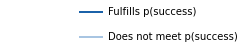

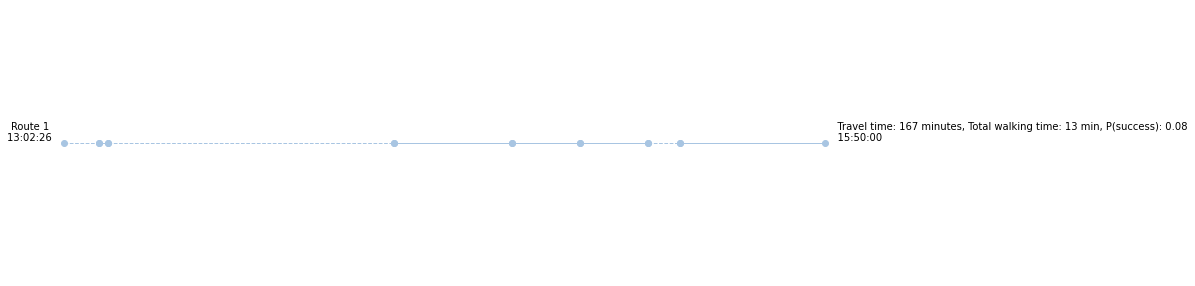

In [45]:
choose_trip = get_choosetrip_w(route)
figure, stops_tot, transport_type , arrival_tot, departure_tot, x_tot, keep_index_tot, type_edge_tot, route_name_tot, headsign_tot, stops_id_tot, trip_id_tot= timetable_overview(route, travel_success, n_trips)
choose_trip

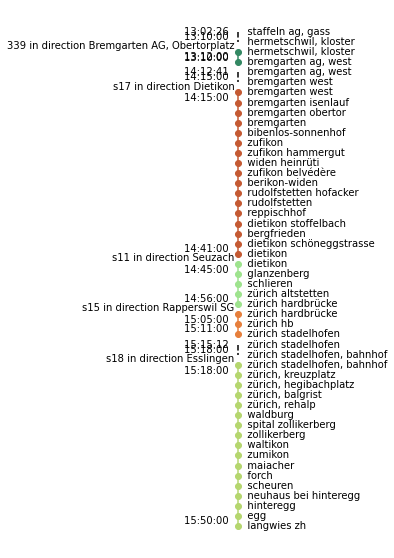

In [46]:
y_label, color_segment, departure_seg, arrival_seg, travel_name, line_style, figure  = detailed_viz1(choose_trip, stops_tot, route_name_tot, headsign_tot, trip_id_tot, keep_index_tot, type_edge_tot, departure_tot, arrival_tot)

![Staffeln AG -> Illnau, Horben](../modules/validation_images/validation3_sbb.png)

In this last example, there are two main differences between our planner and the SBB planner.

1. This difference is due to an algorithmic limitation

- The shortest path from Bremgarten AG to destination, takes the bus direction Bremgarten AG, Obertorplatz
- This bus does not go through source node Staffeln AG, Gass

Indeed, our algorithm computes the shortest path from each node to destination. Thus, to determine the shortest path from Staffeln AG, Gass to destination, the path goes through the shortest path from Bremgarten AG to destination, which involves a bus that does not go through Staffeln AG, Gass. The most optimal path would have been to take a less optimal path from Bremgarten AG to destination, something our algorithm is not capable of.

Thus,
- Needs to walk or transfer from Staffeln AG, Gass to Bremgarten AG, West
- Walking is optimal at this timing, as there was no time for a transfer, and walking is faster than waiting for the next bus and taking it.

2. The difference is due to Robust assumptions that impose a 2min transfer time and a 2min min. walking time.\
Thus, the algorithm does not allow the transfer between Illnau, Bahnhof and Illnau, Platform 1